# Setup Code

The Analysis in this notebook is mainly on 

1. Averaging across control trajectories
2. Collapsing across numSketch via max/avg/argmax 

In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable
# import sys
# sys.path.insert(0, '/home/rslee/sketchfeat/sketches')


# import embedding as emb
# reload(emb)
# from embedding import *


import pandas as pd
import pickle

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3




In [2]:
# partial = pd.read_csv('/home/rslee/sketchfeat/0110171_partial.csv')
partial = pd.read_csv('/Users/sasha/Documents/sketchfeat_data/partial_sketch_full.csv')
partial['curr_winner'] = partial[['bed', 'bench', 'chair', 'table']].idxmax(axis = 1)
partial['tc_pair'] = partial[['target', 'competitor']].apply(
                                    lambda x: '{:s}/{:s}'.format(x[0], x[1]), axis = 1)
partial['trialID'] = partial[['wID', 'trial']].apply(
                                    lambda x: '{:s}_{:d}'.format(x[0], x[1]), axis = 1)
partial['run'] = partial['trial'].apply(
                                    lambda x: np.floor((x - 300)/10) - 1)




In [3]:
def convert_label_to_index(labels):
    labels[labels == 'bed'] = 9
    labels[labels == 'bench'] = 10
    labels[labels == 'chair'] = 11
    labels[labels == 'table'] = 12
    labels = [int(x) for x in labels]
    return labels
    
    
target_labels = convert_label_to_index(np.copy(partial['target'].values))
comp_labels = convert_label_to_index(np.copy(partial['competitor'].values))
controls = np.array([np.setdiff1d(np.arange(9,13), x) for x in np.column_stack([target_labels, comp_labels])])
control1 = controls[:,0]
control2 = controls[:,1]

In [4]:
partial['target_val'] = partial.values[np.arange(len(partial)), target_labels]
partial['competitor_val'] = partial.values[np.arange(len(partial)), comp_labels]
partial['control_val'] = np.mean(np.array([partial.values[np.arange(len(partial)), control1], partial.values[np.arange(len(partial)), control2]]), axis = 0)


In [5]:
# metadata from the csv 
subject_names = np.unique(partial['wID'])
num_psketch = len(np.unique(partial['numSketch']))
trials = np.unique(partial['trial'])
categories = ['bed', 'bench', 'chair', 'table']
tc_pairs = np.unique(partial['tc_pair'])
runs = np.unique(partial['run'])
print ('Number of subjects: {:d}'.format(len(subject_names)))
print ('Number of partial skecthes: {:d}'.format(num_psketch))
print ('Number of trials per subject: {:d}'.format(len(trials)))
print ('Number of target/competitor pairs: {:d}'.format(len(tc_pairs)))

Number of subjects: 35
Number of partial skecthes: 23
Number of trials per subject: 40
Number of target/competitor pairs: 12


In [6]:
# helper functions 
    
def plot_average_response_by_cat(df, show_legend = 1):

    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'bed', color = 'b')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'bench', color = 'r')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'chair', color = 'g')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'table', color = 'y')

    if show_legend == 1:
        plt.legend(['bed', 'bench', 'chair', 'table'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.ylabel('Probability Estaimtes \n (L2 normalized Log Reg)')
    
    
    at_corr = AnchoredText('{:.2f} % correct \n for final sketches'.format(get_percent_correct(df)),
                  prop=dict(size=14), frameon=True,
                  loc=1,
                  )

    at_target = AnchoredText('Targets: {:s} \nCompetitors: {:s} \nControls: {:s}'
                             .format(str(np.unique(df['target'])), str(np.unique(df['competitor'])), 
                                    str([x for x in categories if x not in np.unique(df[['target', 'competitor']])])),
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )


    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.add_artist(at_corr)
    axes.add_artist(at_target)


def plot_average_response(df, show_legend = 1, show_targets = 1):

    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'target_val', color = 'b')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'competitor_val', color = 'r')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'control_val', color = 'g')



    plt.ylabel('Probability Estaimtes \n (L2 normalized Log Reg)')
    
    
    at_corr = AnchoredText('{:.2f} % correct \n for final sketches'.format(get_percent_correct(df)),
                  prop=dict(size=14), frameon=True,
                  loc=1,
                  )

    at_target = AnchoredText('Targets: {:s} \nCompetitors: {:s} \nControls: {:s}'
                             .format(str(np.unique(df['target'])), str(np.unique(df['competitor'])), 
                                    str([x for x in categories if x not in np.unique(df[['target', 'competitor']])])),
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )


    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.add_artist(at_corr)

    if show_legend == 1:
        plt.legend(['target', 'competitor', 'control (avg)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if show_targets == 1: 
        axes.add_artist(at_target)

        
def plot_average_response_by_run(df_full, num_subplots = 1, s_i = 0):
    for r_i, r in enumerate(runs):
        plt.subplot(num_subplots, len(runs), (s_i * 4)  + r_i + 1)
        df = df_full[df_full['run'] == r]
        sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'target_val', color = 'b')
        sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'competitor_val', color = 'r')
        sns.tsplot(data = df, time = 'numSketch', unit = 'trialID', value = 'control_val', color = 'g')

        if r_i == 0:
            plt.ylabel('Probability Estaimtes \n (L2 normalized Log Reg)')
        else:
            plt.ylabel('')


        at_corr = AnchoredText('{:.2f} % correct \n for final sketches'.format(get_percent_correct(df)),
                      prop=dict(size=14), frameon=True,
                      loc=1,
                      )



        axes = plt.gca()
        axes.set_ylim([0,1])
        axes.add_artist(at_corr)

        if r_i == 3:
            plt.legend(['target', 'competitor', 'control (avg)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    



    
def get_final_sketch(df):
    return df[df['numSketch'] == num_psketch -1]


def get_num_correct(df, disp = 0): 
    num_correct = sum(get_final_sketch(df).target == get_final_sketch(df).curr_winner);
    if disp == 1: 
        print(pd.concat([get_final_sketch(df).target, get_final_sketch(df).curr_winner], axis = 1));
    return num_correct


def get_percent_correct(df, disp = 0):
    return round((get_num_correct(df, disp) / len(get_final_sketch(df))) * 100, 2)

# I. Pooling all subjects and objects

This is the mean evidence for the target/competitor/control1/control2. So this amounts to the averaged version of the first plot. 

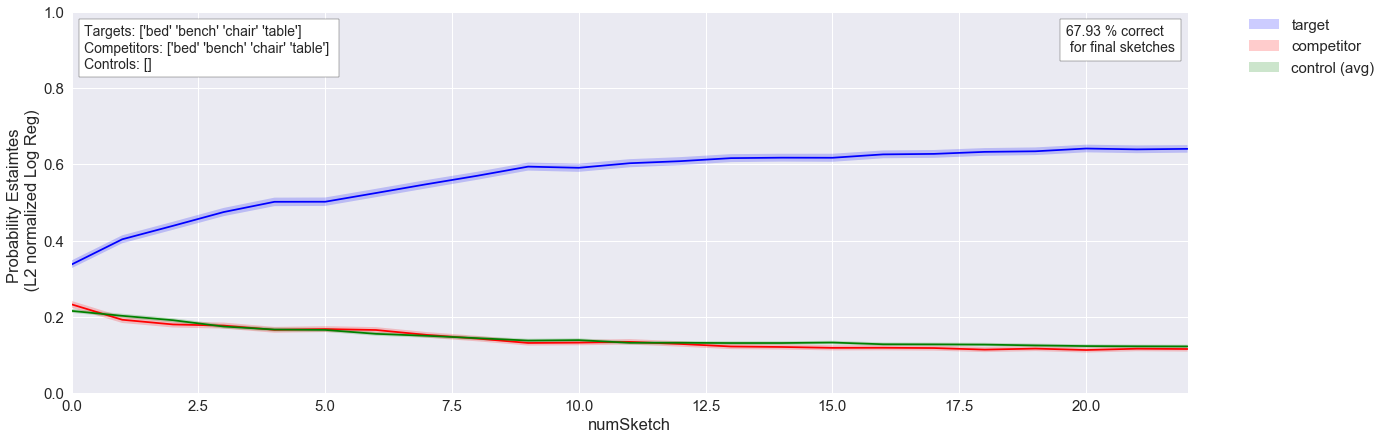

In [7]:
figure = plt.figure(figsize = (20, 7))

plot_average_response(partial)



## b. Pooling all subjects and objects (by runs)

Same as above but organized by runs

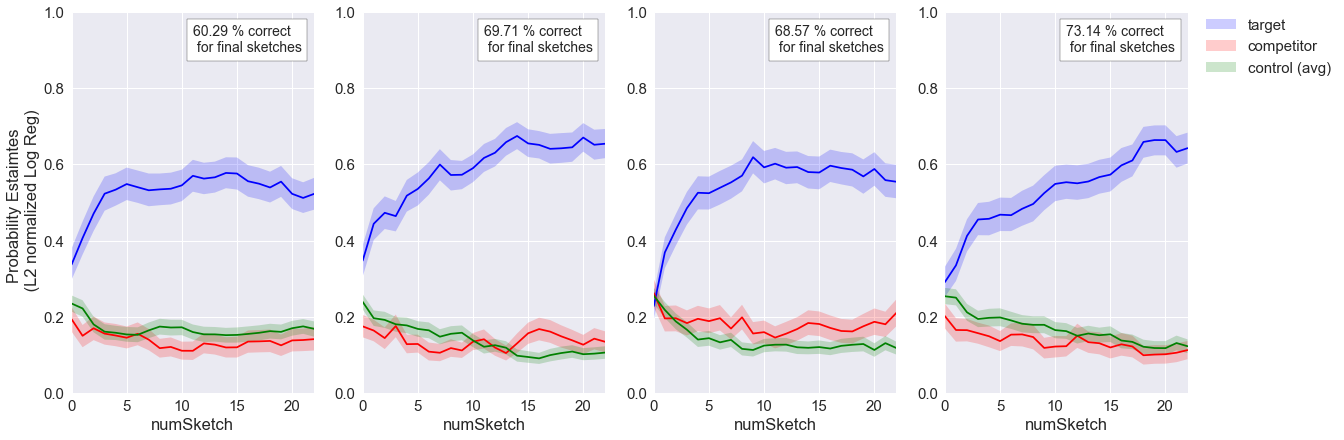

In [10]:
figure = plt.figure(figsize = (20, 7))


plot_average_response_by_run(partial)



# II. Mean Evidence for target/competitor/control over time per subject

This is collapsing across which object was actually drawn on each trial. Control1 and control2 could be the other two objects, sorted alphabetically. This generates as many plots as there are subjects. 



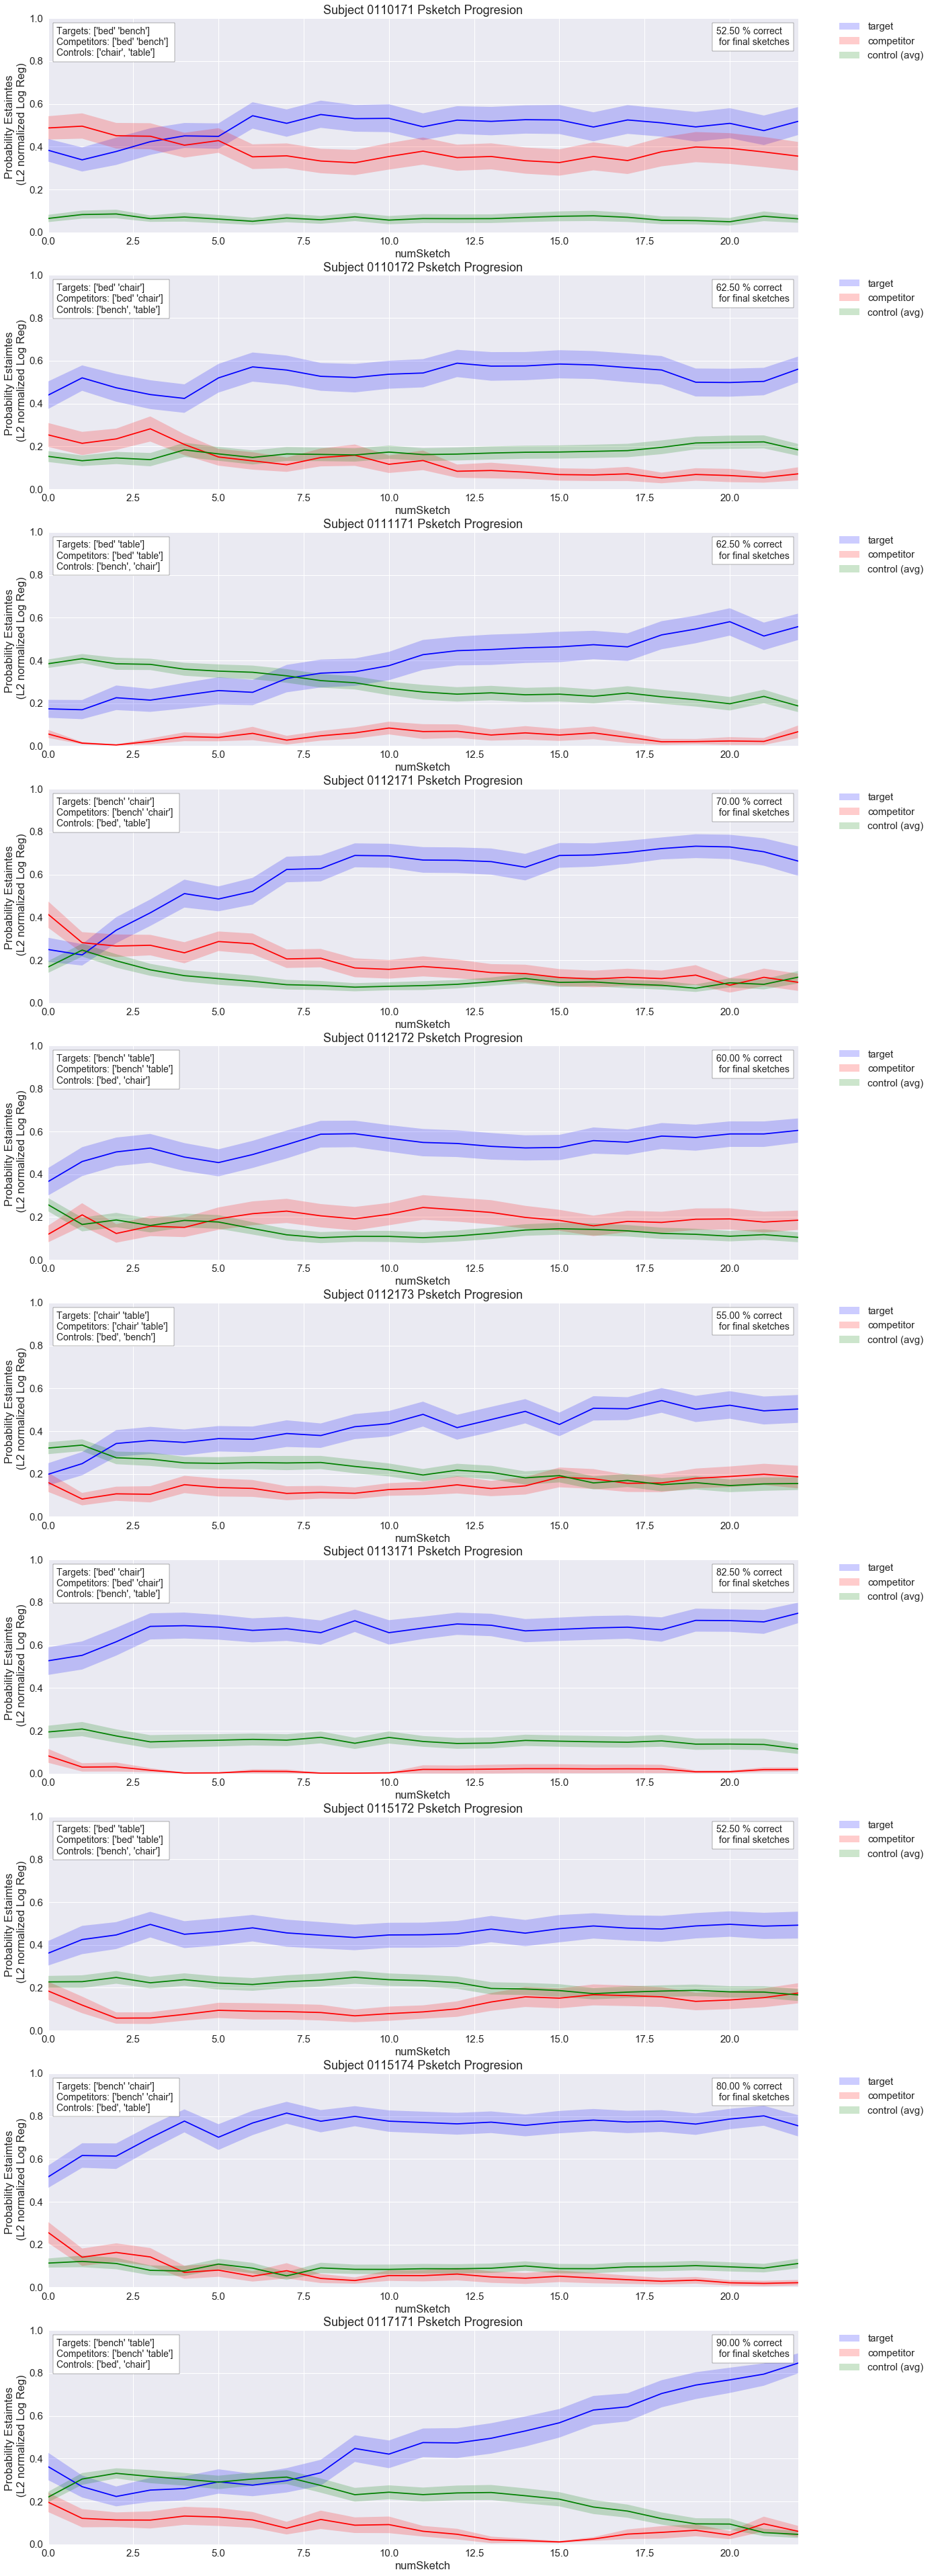

In [11]:
figure = plt.figure(figsize = (20, 7 * len(subject_names)))

for s_i, s in enumerate(subject_names[0:10]):
    plt.subplot(len(subject_names), 1, s_i + 1)
    partial_i = partial[partial['wID'] == s]
    plt.title('Subject {:s} Psketch Progresion'.format(s.split('_')[0]))
    plot_average_response(partial_i.reset_index())

    

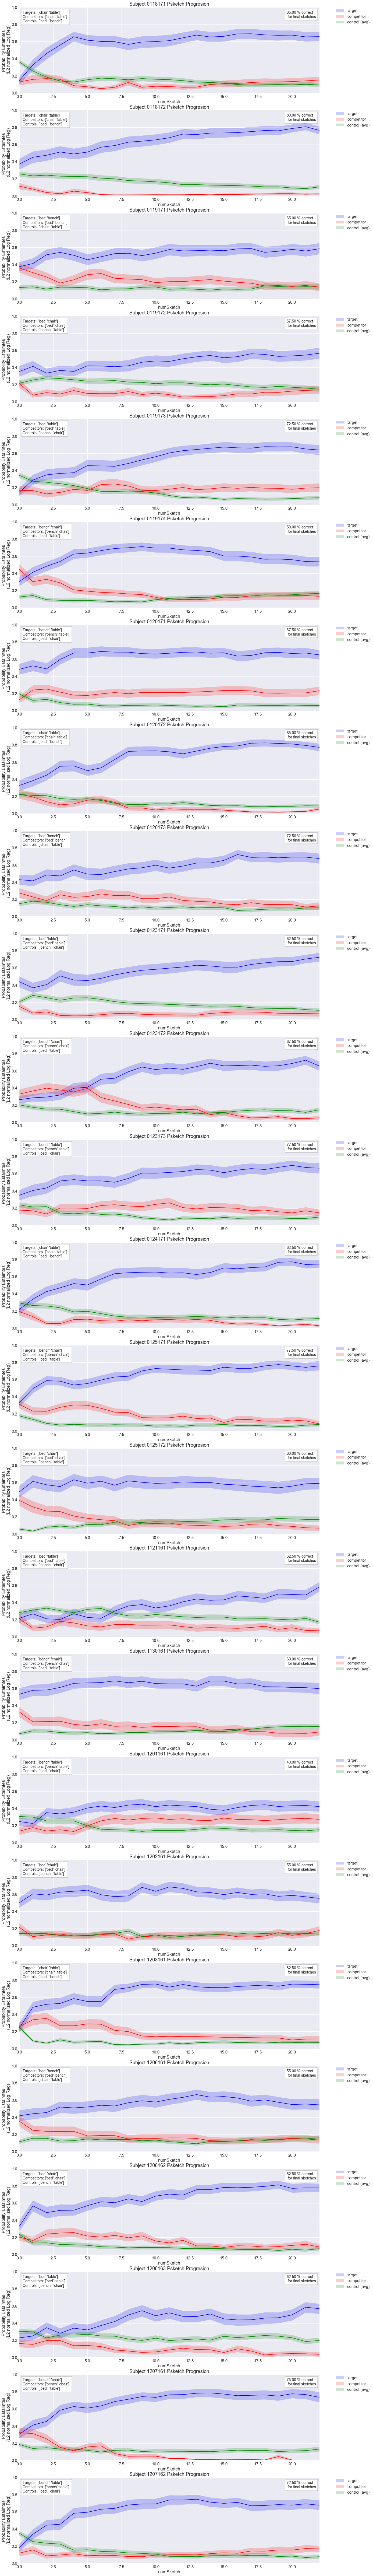

In [12]:
figure = plt.figure(figsize = (20, 7 * len(subject_names)))

for s_i, s in enumerate(subject_names[10:]):
    plt.subplot(len(subject_names), 1, s_i + 1)
    partial_i = partial[partial['wID'] == s]
    plt.title('Subject {:s} Psketch Progresion'.format(s.split('_')[0]))
    plot_average_response(partial_i.reset_index())

# Mean Evidence for target/competitor/control over time per target/competitor pair 

For each target/competitor pair, the mean evidence over time. This is collapsing across subjects to evaluate the variability across items. So, for example, a few subjects were trained on bed/bench. On bed trials, how does evidence vary over time in absolute terms, and relative to bench? And vice versa. This generates 12 plots, two for each pair.


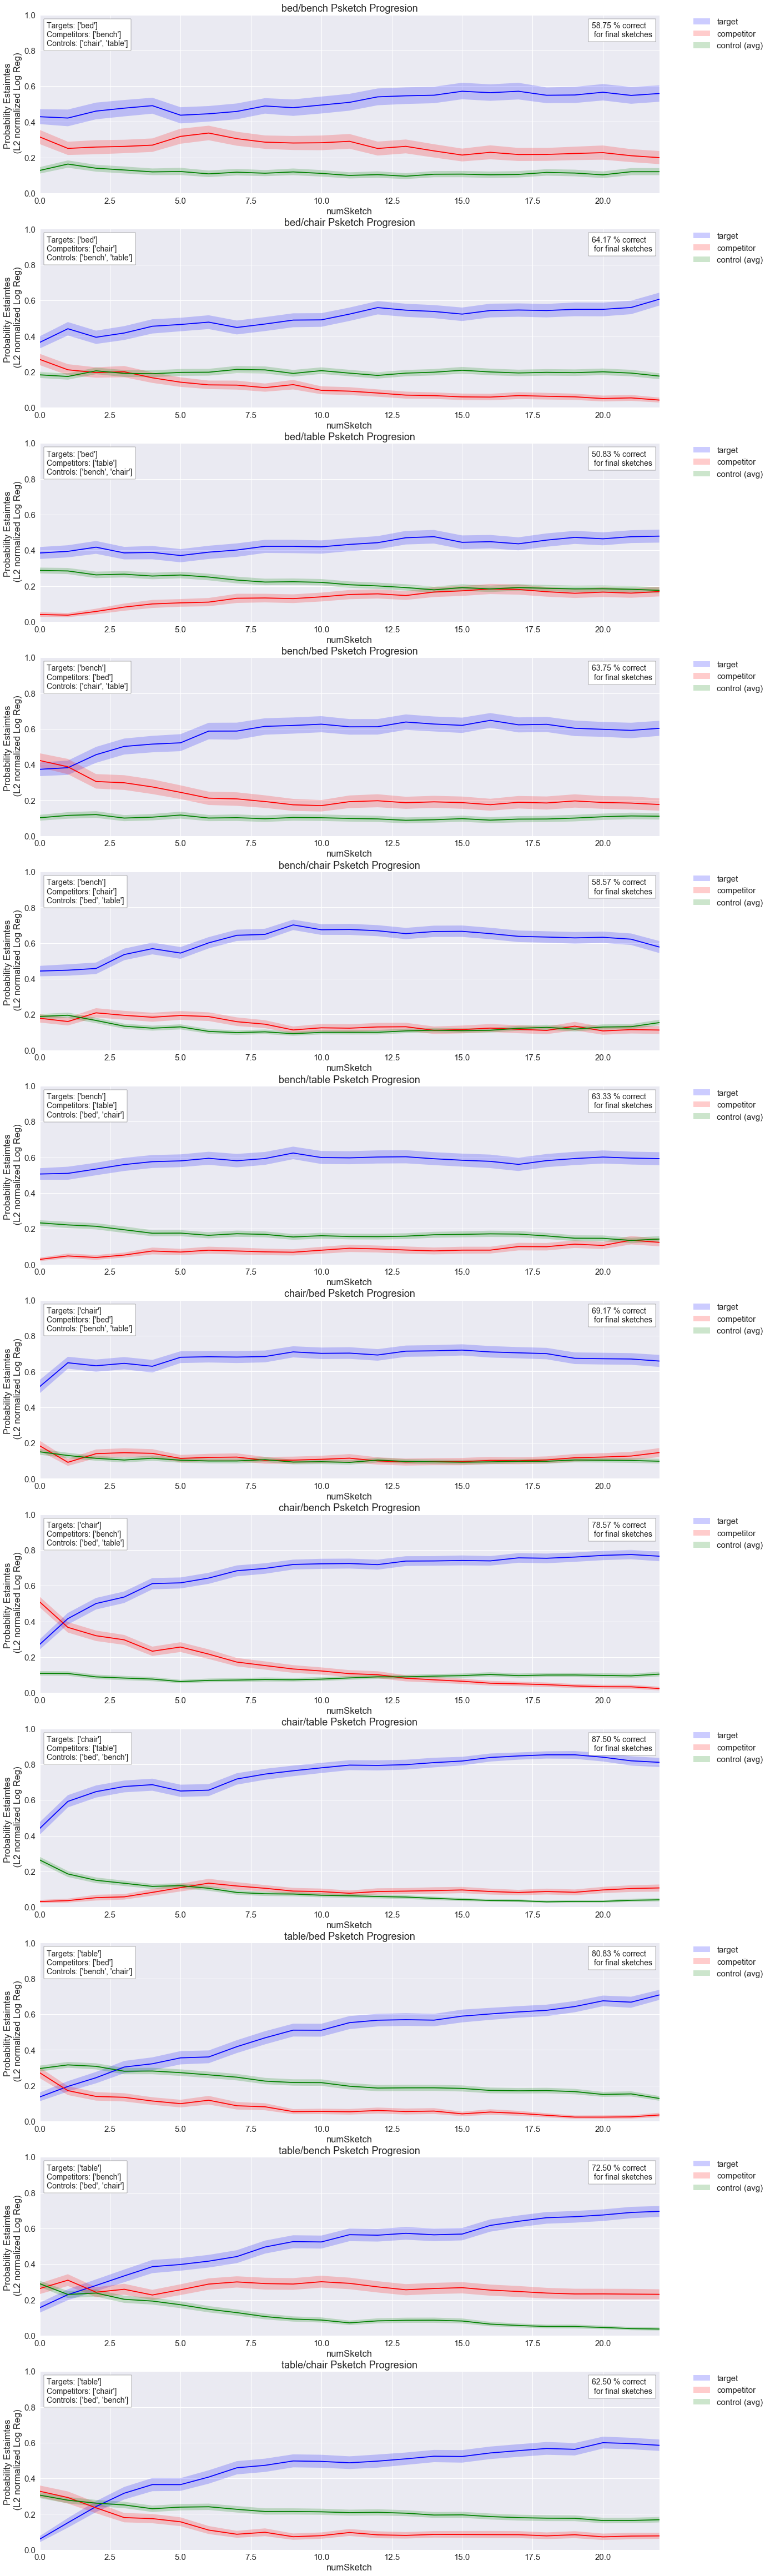

In [13]:
figure = plt.figure(figsize = (20, 7 * len(tc_pairs)))

for tc_i, tc in enumerate(tc_pairs):
    plt.subplot(len(tc_pairs), 1, tc_i + 1)
    partial_i = partial[partial['tc_pair'] == tc]
    plt.title('{:s} Psketch Progresion'.format(tc))
    plot_average_response(partial_i.reset_index())



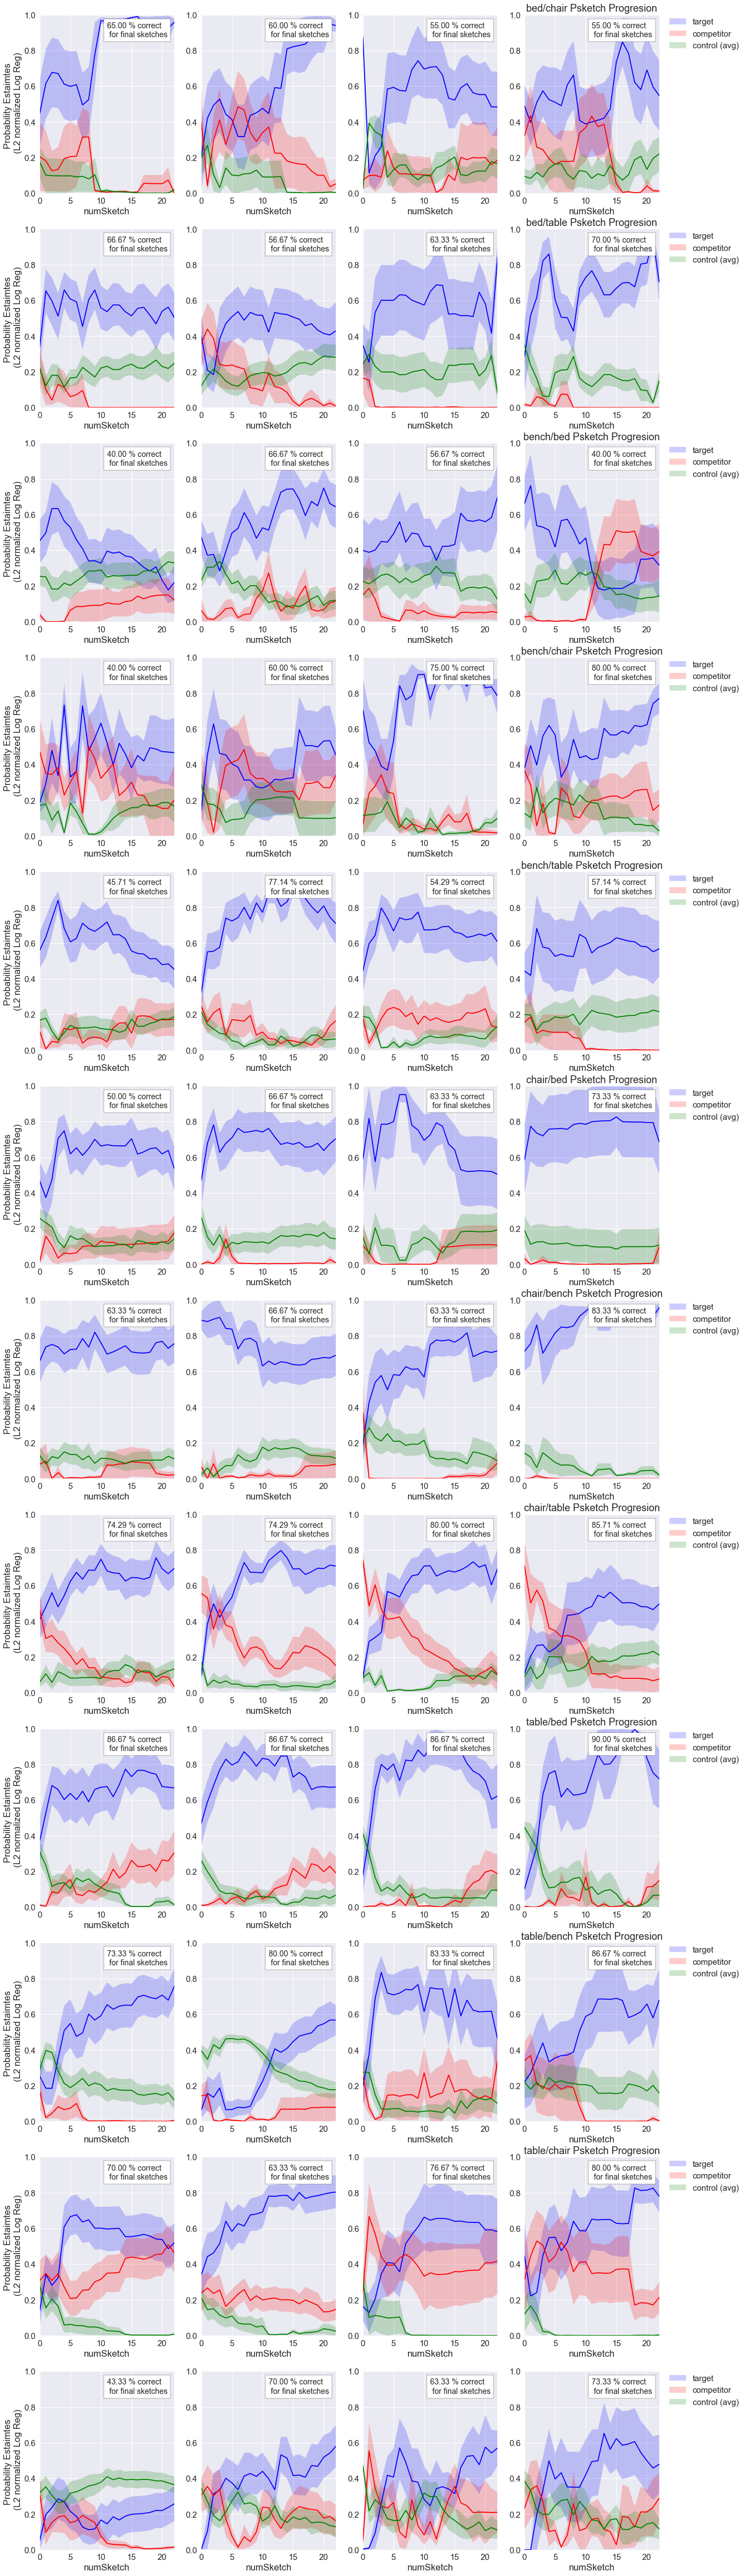

In [14]:
figure = plt.figure(figsize = (20, 7 * len(tc_pairs)))

for tc_i, tc in enumerate(tc_pairs):
    partial_i = partial[partial['tc_pair'] == tc]
    plt.title('{:s} Psketch Progresion'.format(tc))
    plot_average_response_by_run(partial_i.reset_index(), num_subplots =len(tc_pairs), s_i = tc_i)



# IV. Collapsing Across Sketch Progression

We now look at the max activation of target vs competitor vs control over the 40 trials


In [7]:
trials = np.unique(partial['trial'])
max_t = np.zeros((40, 2), float)

max_c = np.zeros((40, 2), float)

max_ct = np.zeros((40, 2), float)
for t_i, t in enumerate(trials): 
    partial_i = partial[partial['trial'] == t]
    
    max_t[t_i, 0] = np.mean(partial_i.groupby('wID')['target_val'].max())
    max_loc = partial_i.groupby('wID')['target_val'].idxmax()
    max_t[t_i, 1] = np.mean(partial_i.loc[max_loc, 'numSketch'])
    
    max_c[t_i, 0] = np.mean(partial_i.groupby('wID')['competitor_val'].max())
    max_loc = partial_i.groupby('wID')['competitor_val'].idxmax()
    max_c[t_i, 1] = np.mean(partial_i.loc[max_loc, 'numSketch'])
    
    max_ct[t_i, 0] = np.mean(partial_i.groupby('wID')['control_val'].max())
    max_loc = partial_i.groupby('wID')['control_val'].idxmax()
    max_ct[t_i, 1] = np.mean(partial_i.loc[max_loc, 'numSketch'])

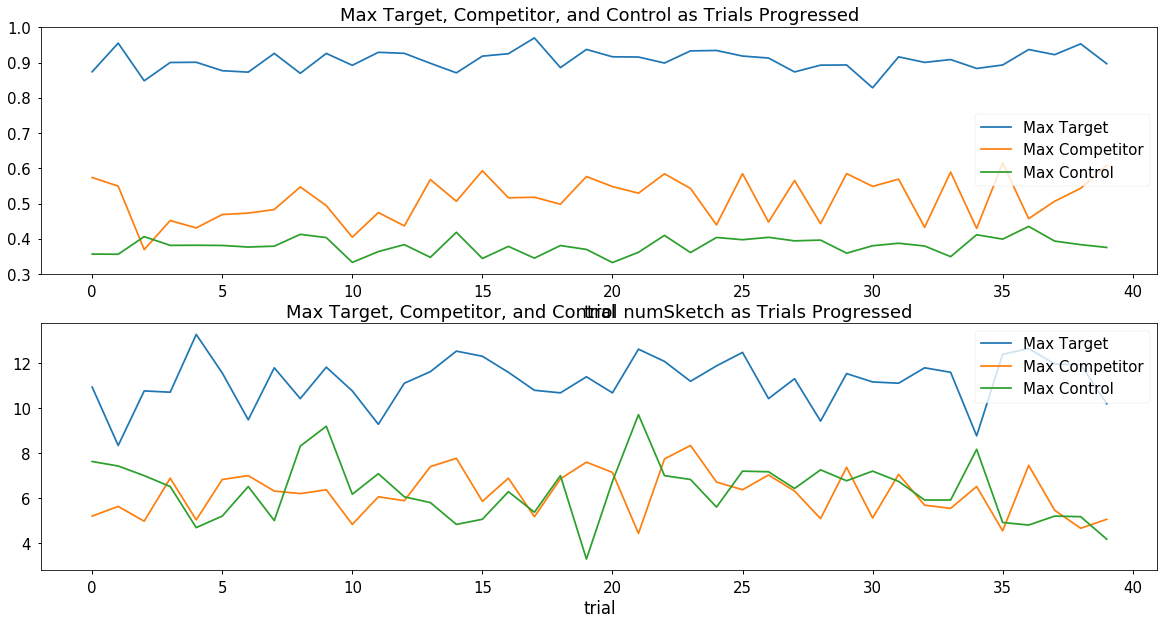

In [12]:
figure = plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(max_t[:,0], label='Max Target')
plt.plot(max_c[:,0], label='Max Competitor')
plt.plot(max_ct[:,0], label = 'Max Control')
plt.legend()
plt.xlabel('trial')
plt.title('Max Target, Competitor, and Control as Trials Progressed')

plt.subplot(2, 1, 2)
plt.plot(max_t[:,1], label='Max Target')
plt.plot(max_c[:,1], label='Max Competitor')
plt.plot(max_ct[:,1], label = 'Max Control')
plt.legend()
plt.xlabel('trial')
plt.title('Max Target, Competitor, and Control numSketch as Trials Progressed')


In [15]:
trials = np.unique(partial['trial'])
mean_t = np.zeros((40, 1), float)
mean_c = np.zeros((40, 1), float)
mean_ct = np.zeros((40, 1), float)
for t_i, t in enumerate(trials): 
    partial_i = partial[partial['trial'] == t]
    mean_t[t_i] = np.mean(partial_i['target_val'])
    mean_c[t_i] = np.mean(partial_i['competitor_val'])
    mean_ct[t_i] = np.mean(partial_i['control_val'])


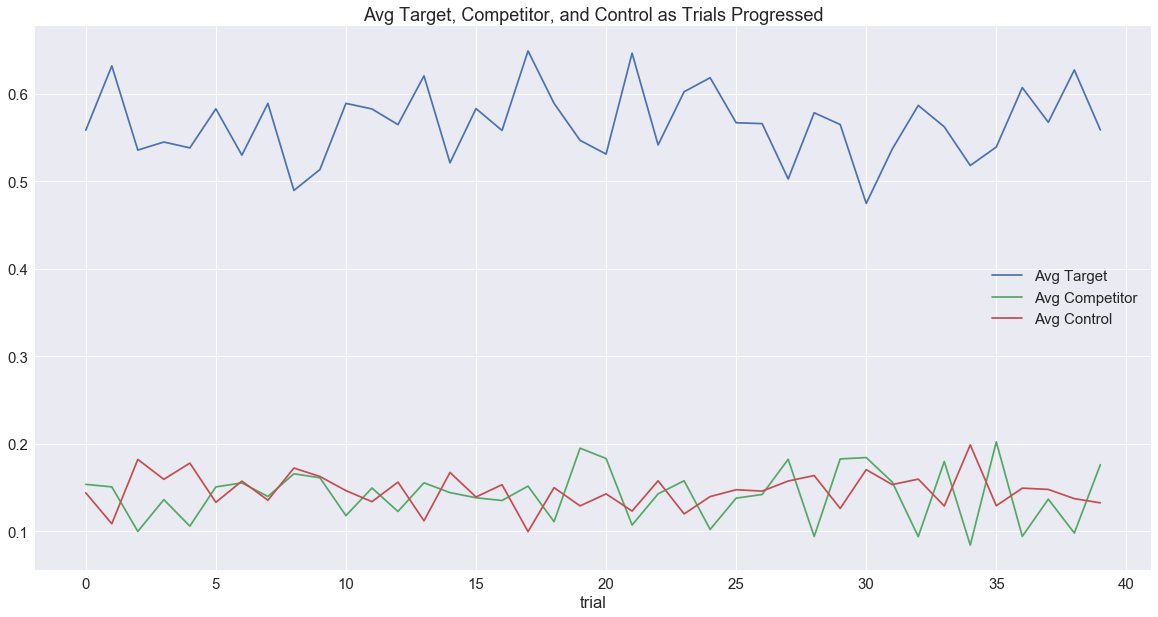

In [22]:
figure = plt.figure(figsize = (20, 10))
plt.plot(mean_t, label='Avg Target')
plt.plot(mean_c, label='Avg Competitor')
plt.plot(mean_ct, label = 'Avg Control')
plt.legend()

plt.xlabel('trial')
plt.title('Avg Target, Competitor, and Control as Trials Progressed')